# Exploring LAPD Stop Data

In [299]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
from matplotlib import style as style

### Questions
1. Are certain races stopped at higher rates? Has this changed over time?
2. Do stop rates differ between races based on the type of stop or time of day?
3. Are there disparities in "post stop activity" - whether or not an officer will frisk, search, cite, or arrest the person they stopped? Has this changed over time?

## Load the data

In [359]:
df = pd.read_csv('Vehicle_and_Pedestrian_Stop_Data_2010_to_Present.csv', parse_dates = ['Stop Date', 'Stop Time'])

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Cleaning the Data and Handling Null Values

In [360]:
# split the date and time into separate columns

df['Stop Year'] = df['Stop Date'].dt.year
df['Stop Month'] = df['Stop Date'].dt.month
df['Stop Day'] = df['Stop Date'].dt.day
df['Stop Day Name'] = df['Stop Date'].dt.dayofweek
df['Stop Time'] = pd.to_datetime(df['Stop Time'])
df['Stop Hour'] = df['Stop Time'].dt.hour

# remove this outlier
df = df.drop(df[df['Stop Year'] == 1900].index)


df = df.drop(['Officer 2 Serial Number', 'Officer 2 Division Number', 'Division Description 2', 'Descent Code', 'Division Description 1', 'Officer 1 Serial Number', 'Officer 1 Division Number'], axis=1, errors='ignore') # Columns I don't need

In [361]:
print(df.isnull().sum())       
print(df.isnull().mean())

Stop Number                       0
Form Reference Number             0
Sex Code                          0
Descent Description               0
Stop Date                         1
Stop Time                         0
Reporting District                0
Stop Type                         1
Post Stop Activity Indicator    175
Stop Year                         1
Stop Month                        1
Stop Day                          1
Stop Day Name                     1
Stop Hour                         0
dtype: int64
Stop Number                     0.000000e+00
Form Reference Number           0.000000e+00
Sex Code                        0.000000e+00
Descent Description             0.000000e+00
Stop Date                       1.267192e-07
Stop Time                       0.000000e+00
Reporting District              0.000000e+00
Stop Type                       1.267192e-07
Post Stop Activity Indicator    2.217586e-05
Stop Year                       1.267192e-07
Stop Month                      1

In [362]:
df.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7891464 entries, 0 to 7891464
Data columns (total 14 columns):
Stop Number                     int64
Form Reference Number           int64
Sex Code                        object
Descent Description             object
Stop Date                       datetime64[ns]
Stop Time                       datetime64[ns]
Reporting District              object
Stop Type                       object
Post Stop Activity Indicator    object
Stop Year                       float64
Stop Month                      float64
Stop Day                        float64
Stop Day Name                   float64
Stop Hour                       int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(5)
memory usage: 903.1+ MB


In [363]:
# Since the percentage of missing values is so small 0.002%, we can simply drop the rows containing any null values.
df = df.dropna(axis=0)
print(df.isnull().sum())

Stop Number                     0
Form Reference Number           0
Sex Code                        0
Descent Description             0
Stop Date                       0
Stop Time                       0
Reporting District              0
Stop Type                       0
Post Stop Activity Indicator    0
Stop Year                       0
Stop Month                      0
Stop Day                        0
Stop Day Name                   0
Stop Hour                       0
dtype: int64


In [364]:
# Because the memory usage is quite large. I am going to try to convert some of the data types to use less memory. 
data_types = {'Stop Year':'uint16', 'Stop Month':'uint8', 'Stop Day':'uint8', 'Stop Day Name':'uint8', 'Sex Code':'category', 
              'Descent Description':'category', 'Stop Type':'category', 'Post Stop Activity Indicator':'category'}

df = df.astype(data_types)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7891288 entries, 0 to 7891464
Data columns (total 14 columns):
Stop Number                     int64
Form Reference Number           int64
Sex Code                        category
Descent Description             category
Stop Date                       datetime64[ns]
Stop Time                       datetime64[ns]
Reporting District              object
Stop Type                       category
Post Stop Activity Indicator    category
Stop Year                       uint16
Stop Month                      uint8
Stop Day                        uint8
Stop Day Name                   uint8
Stop Hour                       int64
dtypes: category(4), datetime64[ns](2), int64(3), object(1), uint16(1), uint8(3)
memory usage: 489.2+ MB


In [306]:
sns.set_style('darkgrid')

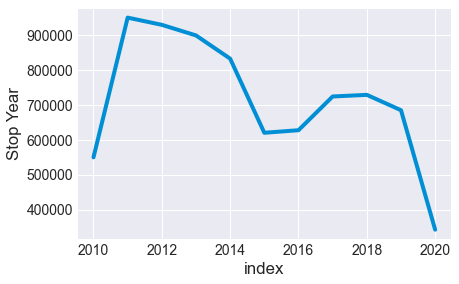

In [307]:
# Lets see how the number of stops have varied over time. 

stops_per_year = pd.DataFrame(df['Stop Year'].value_counts()).reset_index()
stops_per_year
sns.lineplot(x='index', y='Stop Year', data=stops_per_year)

['HISPANIC', 'BLACK', 'WHITE', 'OTHER', 'ASIAN', 'MULTI-DESCENTS', 'AMERICAN INDIAN']


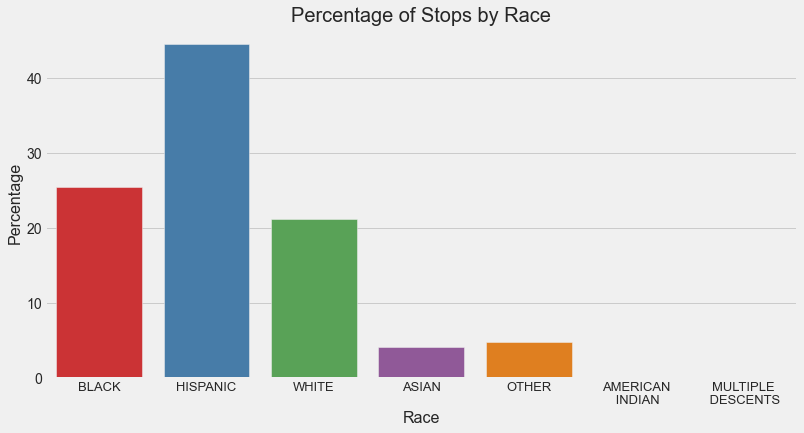

In [308]:
style.use('fivethirtyeight')


race_breakdown = pd.DataFrame(df['Descent Description'].value_counts(normalize=True)).sort_values('Descent Description', ascending=False).reset_index()
race_breakdown = race_breakdown.rename(columns={'index':'Race', 'Descent Description':'Percentage'})
print(race_breakdown['Race'].tolist())

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=race_breakdown['Race'], y=race_breakdown['Percentage'], order=['BLACK', 'HISPANIC', 'WHITE', 'ASIAN', 'OTHER', 'AMERICAN INDIAN', 'MULTI-DESCENT'], ax=ax, palette='Set1')
ax.set_title('Percentage of Stops by Race', fontsize=20)
ax.set_xlabel('Race', fontsize=16)
ax.set_xticklabels(['BLACK', 'HISPANIC', 'WHITE', 'ASIAN', 'OTHER', 'AMERICAN\n INDIAN', 'MULTIPLE\n DESCENTS'], fontsize=13)
ax.set_ylabel('Percentage', fontsize=16)
ax.set_yticklabels([0, 10, 20, 30, 40])

plt.savefig('Percent_stops_by_race.jpg')

In [366]:
# plit the data so I can compare the first half of the decade and the last half

stops_2010 = df[df['Stop Year'].between(2010, 2014)]
stops_2015 = df[df['Stop Year'].between(2015, 2019)]

stops_2010.shape, stops_2015.shape

((4162451, 14), (3386403, 14))

In [367]:
# I got this data from the http://www.laalmanac.com/population/po38_2010.php
la_population = {'AMERICAN INDIAN':28065, 'ASIAN':427049, 'BLACK':365229, 'OTHER':908712, 'MULTI-DESCENTS':175598, 'WHITE':1086965, 'HISPANIC':1838663}


array([1086965.1786,  365229.4023,   28065.3954,  427049.1246,
        908711.9916,  175598.3523, 1838662.6608])

In [311]:
# I divide the number of stops by the population of that race, and then multiply by 10000 to get the stops per 10000 people to normalize the number across the different race populations. 

stops_race_normalized = pd.DataFrame(df['Descent Description'].value_counts()).reset_index()
stops_race_normalized['Stops per 10000'] = stops_race_normalized.apply(lambda x: 10000 * x['Descent Description'] / la_population[x['index']], axis=1)
stops_race_normalized['Annual Stops per 10000'] = stops_race_normalized['Stops per 10000'] / 10   # I divide by 10 so that I've have an average per year, not for the whole decade.
stops_race_normalized


,index,Descent Description,Stops per 10000,Annual Stops per 10000
0,HISPANIC,3509704,19088.348436,1908.834844
1,BLACK,2008205,54984.817744,5498.481774
2,WHITE,1667858,15344.173915,1534.417392
3,OTHER,368605,4056.345685,405.634568
4,ASIAN,323986,7586.623549,758.662355
5,MULTI-DESCENTS,7525,428.535633,42.853563
6,AMERICAN INDIAN,5405,1925.886335,192.588634


In [312]:
df['count'] = 1 # This will be helpful to use pivot_tables. I could also use value_counts but I prefer this method. 

In [313]:
race_year = pd.pivot_table(df, index='Stop Year', columns='Descent Description', values='count', aggfunc=np.sum, fill_value=0)
race_year

Descent Description,AMERICAN INDIAN,ASIAN,BLACK,HISPANIC,MULTI-DESCENTS,OTHER,WHITE
Stop Year,,,,,,,
2010,457,24892,109899,220850,0,30561,163269
2011,904,36633,228034,405954,0,49533,229415
2012,626,36404,224933,400381,0,50796,216656
2013,611,32455,219993,393922,0,50098,202366
2014,498,29246,197663,373428,0,53119,178855
2015,369,19863,161108,279592,0,36155,123228
2016,344,17998,171107,290632,0,34935,112661
2017,413,21126,204829,328324,0,40765,128927
2018,500,31799,212256,336474,2517,20216,125254


In [314]:
la_population = {'AMERICAN INDIAN':28065, 'ASIAN':427049, 'BLACK':365229, 'OTHER':908712, 'MULTI-DESCENTS':175598, 'WHITE':1086965, 'HISPANIC':1838663}



In [316]:
la_pop_array = np.array([28065, 427049, 365229, 1838663, 175598, 908712, 1086965])   # I reordered these numbers to match the order of the columns in the dataframe. 

race_year_per_10000 = 10000 * np.divide(race_year, la_pop_array)   # The number of stops per 10000 residents by race and year
race_year_per_10000


Descent Description,AMERICAN INDIAN,ASIAN,BLACK,HISPANIC,MULTI-DESCENTS,OTHER,WHITE
Stop Year,,,,,,,
2010,162.836273,582.883931,3009.043641,1201.144527,0.000000,336.311174,1502.063084
2011,322.109389,857.817253,6243.589638,2207.876049,0.000000,545.090194,2110.601537
2012,223.053626,852.454871,6158.684004,2177.565981,0.000000,558.988987,1993.219653
2013,217.708890,759.983046,6023.426398,2142.437195,0.000000,551.307785,1861.752678
2014,177.445216,684.839445,5412.029165,2030.975769,0.000000,584.552642,1645.453165
2015,131.480492,465.122269,4411.150265,1520.626673,0.000000,397.870833,1133.688757
2016,122.572599,421.450466,4684.923705,1580.670302,0.000000,384.445237,1036.473116
2017,147.158382,494.697330,5608.234833,1785.667085,0.000000,448.601977,1186.119148
2018,178.157848,744.621812,5811.586703,1829.992772,143.338762,222.468725,1152.327812


In [317]:
race_2010 = race_year_per_10000.loc[2010:2014].mean()    # Average over the first half of decade
race_2015 = race_year_per_10000.loc[2015:2019].mean()    # Average over the second half of decade.

In [318]:
race_mean = race_year_per_10000.loc[2010:2019].mean()    # Find the overall normalized average number of stops over the whole decade
race_mean_df = pd.DataFrame(race_mean, columns=['Annual Stops per 10000 residents, 2010-2019'])
race_mean_df = race_mean_df.reset_index()
race_mean_df

,Descent Description,"Annual Stops per 10000 residents, 2010-2019"
0,AMERICAN INDIAN,183.930162
1,ASIAN,702.420565
2,BLACK,5248.375677
3,HISPANIC,1819.148479
4,MULTI-DESCENTS,34.413832
5,OTHER,404.812526
6,WHITE,1479.498420


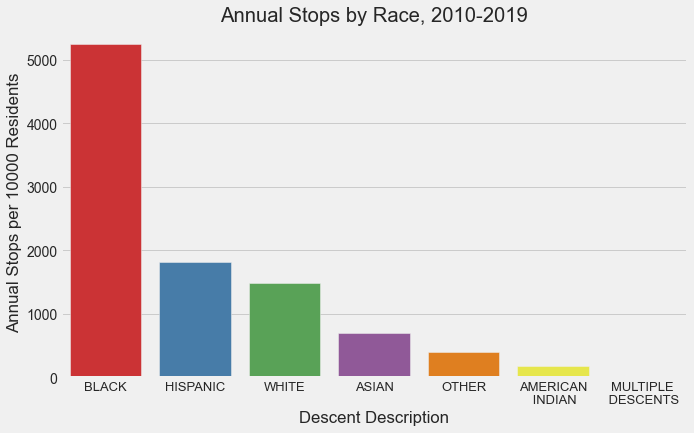

In [319]:
fig, ax1 = plt.subplots(figsize=(10, 6))

race_mean_df = race_mean_df.sort_values('Annual Stops per 10000 residents, 2010-2019', ascending=False)

sns.barplot(race_mean_df['Descent Description'], race_mean_df['Annual Stops per 10000 residents, 2010-2019'], order=['BLACK', 'HISPANIC', 'WHITE', 'ASIAN', 'OTHER', 'AMERICAN INDIAN', 'MULTI-DESCENT'], palette='Set1')

ax1.set_ylabel('Annual Stops per 10000 Residents')
ax1.set_title('Annual Stops by Race, 2010-2019')
ax1.set_xticklabels(['BLACK', 'HISPANIC', 'WHITE', 'ASIAN', 'OTHER', 'AMERICAN\n INDIAN', 'MULTIPLE\n DESCENTS'], fontsize=13)
ax1.grid(False, axis = 'x')

plt.savefig('annual_stops_by_race_2010-2019.jpg')

In [321]:
race_df = pd.DataFrame(race_2010, columns=['Annual Stops per 10000 residents, 2010-2014']).reset_index()

race_df['Annual Stops per 10000 residents, 2015-2019'] = np.array(race_2015)


race_df = race_df.sort_values('Annual Stops per 10000 residents, 2010-2014', ascending=False)
race_df

,Descent Description,"Annual Stops per 10000 residents, 2010-2014","Annual Stops per 10000 residents, 2015-2019"
2,BLACK,5369.354569,5127.396784
3,HISPANIC,1951.999904,1686.297054
6,WHITE,1822.618024,1136.378816
1,ASIAN,747.595709,657.245421
5,OTHER,515.250156,294.374895
0,AMERICAN INDIAN,220.630679,147.229645
4,MULTI-DESCENTS,0.000000,68.827663


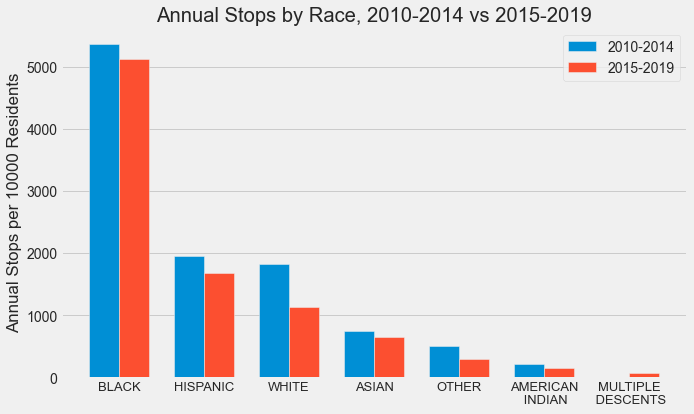

In [322]:
fig, ax2 = plt.subplots(figsize=(10, 6))

ind = np.arange(7)
width = 0.35

rects1 = ax2.bar(ind - width/2, race_df['Annual Stops per 10000 residents, 2010-2014'], width, label = '2010-2014', )
rects2 = ax2.bar(ind + width/2, race_df['Annual Stops per 10000 residents, 2015-2019'], width, label = '2015-2019')

ax2.set_ylabel('Annual Stops per 10000 Residents')
ax2.set_title('Annual Stops by Race, 2010-2014 vs 2015-2019')
ax2.set_xticks(ind)
ax2.set_xticklabels(['BLACK', 'HISPANIC', 'WHITE', 'ASIAN', 'OTHER', 'AMERICAN\n INDIAN', 'MULTIPLE\n DESCENTS'], fontsize=13)
ax2.grid(False, axis = 'x')
ax2.legend()

plt.savefig('annual_stops_by_race_2010-14_vs_2015-2019.jpg')

In [323]:
race_df['percent_decrease'] = 1 - race_df['Annual Stops per 10000 residents, 2015-2019']/race_df['Annual Stops per 10000 residents, 2010-2014']  
race_df

,Descent Description,"Annual Stops per 10000 residents, 2010-2014","Annual Stops per 10000 residents, 2015-2019",percent_decrease
2,BLACK,5369.354569,5127.396784,0.045063
3,HISPANIC,1951.999904,1686.297054,0.136118
6,WHITE,1822.618024,1136.378816,0.376513
1,ASIAN,747.595709,657.245421,0.120854
5,OTHER,515.250156,294.374895,0.428676
0,AMERICAN INDIAN,220.630679,147.229645,0.332687
4,MULTI-DESCENTS,0.000000,68.827663,-inf


## Day vs Night and Pedestrian vs Vehicle Stops.

In [329]:
post_stop_race = df.groupby('Descent Description')['Post Stop Activity Indicator'].value_counts(normalize=True)
post_stop_race_df = pd.DataFrame(post_stop_race)
post_stop_race_df = post_stop_race_df.rename(columns={'Post Stop Activity Indicator':'Percentage'})
post_stop_race_df.reset_index(inplace=True)
post_stop_race_df = post_stop_race_df[post_stop_race_df['Post Stop Activity Indicator'] == 'Y']
post_stop_race_df

,Descent Description,Post Stop Activity Indicator,Percentage
1,AMERICAN INDIAN,Y,0.201480
3,ASIAN,Y,0.131848
5,BLACK,Y,0.345161
7,HISPANIC,Y,0.296063
9,MULTI-DESCENTS,Y,0.397475
11,OTHER,Y,0.106228
13,WHITE,Y,0.165323


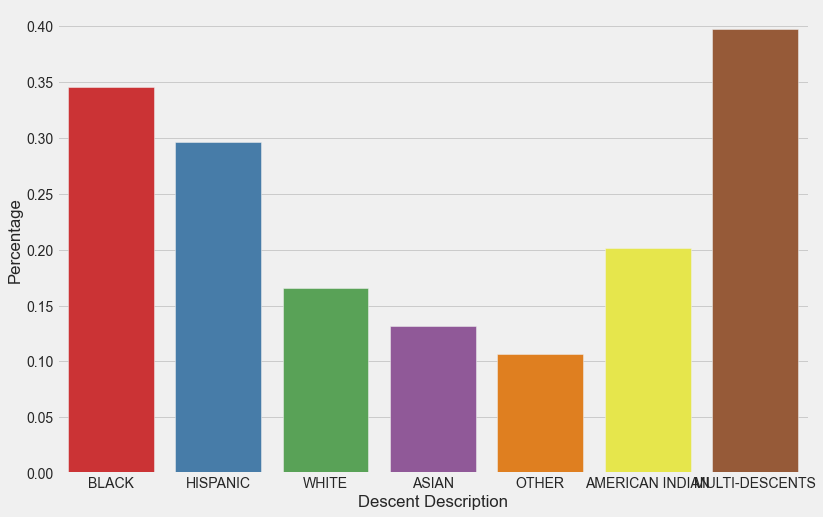

In [330]:
fig, ax3 = plt.subplots(figsize=(12, 8))
sns.barplot(x = 'Descent Description', y='Percentage', data = post_stop_race_df, order=['BLACK', 'HISPANIC', 'WHITE', 'ASIAN', 'OTHER', 'AMERICAN INDIAN', 'MULTI-DESCENTS'], palette = 'Set1')
ax4.set_title('Percentage of Stops that resulted in Post Stop Activity by Race', fontsize=18)
ax4.set_xticklabels(['BLACK', 'HISPANIC', 'WHITE', 'ASIAN', 'OTHER', 'AMERICAN INDIAN', 'MULTI-DESCENTS'], fontsize=11)
plt.savefig('Post Stop Activity.jpg')

Black, Hispanic, and people of Multiple Descents are much more likely to be involved in post stop activity compared to Asian, White, American Indian and Other. 

In [331]:
def time_category(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 20:
        return 'evening'
    else:
        return 'night'

df['Time Category'] = df['Stop Hour'].apply(time_category)
df

,Stop Number,Form Reference Number,Sex Code,Descent Description,Stop Date,Stop Time,Reporting District,Stop Type,Post Stop Activity Indicator,Stop Year,Stop Month,Stop Day,Stop Day Name,Stop Hour,count,Time Category
0,12984268,27426327,M,BLACK,2016-08-06,2020-08-25 21:55:00,1918,PED,N,2016,8,6,5,21,1,night
1,12987768,27429717,F,BLACK,2016-08-09,2020-08-25 00:10:00,974,VEH,N,2016,8,9,1,0,1,night
2,12987840,27429775,F,WHITE,2016-08-09,2020-08-25 19:39:00,822,VEH,N,2016,8,9,1,19,1,evening
3,12991260,27434259,F,ASIAN,2016-08-10,2020-08-25 20:55:00,833,VEH,N,2016,8,10,2,20,1,night
4,12991647,27434592,F,WHITE,2016-08-10,2020-08-25 20:20:00,914,PED,Y,2016,8,10,2,20,1,night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7891460,15813767,32055149,F,WHITE,2020-07-31,2020-08-25 23:45:00,2049,PED,Y,2020,7,31,4,23,1,night
7891461,15813768,32055149,F,HISPANIC,2020-07-31,2020-08-25 23:45:00,2049,PED,Y,2020,7,31,4,23,1,night
7891462,15813769,32055149,F,WHITE,2020-07-31,2020-08-25 23:45:00,2049,PED,Y,2020,7,31,4,23,1,night
7891463,15813770,32055149,F,WHITE,2020-07-31,2020-08-25 23:45:00,2049,PED,Y,2020,7,31,4,23,1,night


In [332]:
df['is_dark'] = 1 - df['Stop Hour'].between(6,19)

df

,Stop Number,Form Reference Number,Sex Code,Descent Description,Stop Date,Stop Time,Reporting District,Stop Type,Post Stop Activity Indicator,Stop Year,Stop Month,Stop Day,Stop Day Name,Stop Hour,count,Time Category,is_dark
0,12984268,27426327,M,BLACK,2016-08-06,2020-08-25 21:55:00,1918,PED,N,2016,8,6,5,21,1,night,1
1,12987768,27429717,F,BLACK,2016-08-09,2020-08-25 00:10:00,974,VEH,N,2016,8,9,1,0,1,night,1
2,12987840,27429775,F,WHITE,2016-08-09,2020-08-25 19:39:00,822,VEH,N,2016,8,9,1,19,1,evening,0
3,12991260,27434259,F,ASIAN,2016-08-10,2020-08-25 20:55:00,833,VEH,N,2016,8,10,2,20,1,night,1
4,12991647,27434592,F,WHITE,2016-08-10,2020-08-25 20:20:00,914,PED,Y,2016,8,10,2,20,1,night,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7891460,15813767,32055149,F,WHITE,2020-07-31,2020-08-25 23:45:00,2049,PED,Y,2020,7,31,4,23,1,night,1
7891461,15813768,32055149,F,HISPANIC,2020-07-31,2020-08-25 23:45:00,2049,PED,Y,2020,7,31,4,23,1,night,1
7891462,15813769,32055149,F,WHITE,2020-07-31,2020-08-25 23:45:00,2049,PED,Y,2020,7,31,4,23,1,night,1
7891463,15813770,32055149,F,WHITE,2020-07-31,2020-08-25 23:45:00,2049,PED,Y,2020,7,31,4,23,1,night,1


In [340]:
dark_df = pd.pivot_table(df, index=['Stop Year', 'Stop Type', 'Descent Description'], columns=['is_dark'], values='count', aggfunc=np.sum).reset_index()

In [341]:
dark_df
#dark_df[dark_df['Stop Year']==2010]

is_dark,Stop Year,Stop Type,Descent Description,0,1
0,2010,PED,AMERICAN INDIAN,68,38
1,2010,PED,ASIAN,1130,683
2,2010,PED,BLACK,26279,13903
3,2010,PED,HISPANIC,35612,24373
4,2010,PED,OTHER,1395,952
...,...,...,...,...,...
133,2020,VEH,BLACK,39519,24488
134,2020,VEH,HISPANIC,84092,37742
135,2020,VEH,MULTI-DESCENTS,655,406
136,2020,VEH,OTHER,442,102


In [342]:
dark_df['stops_per_10000_day'] = dark_df.apply(lambda row: 10000 * row[0]/la_population[row['Descent Description']], axis=1)
dark_df['stops_per_10000_night'] = dark_df.apply(lambda row: 10000 * row[1]/la_population[row['Descent Description']], axis=1)

In [343]:
dark_df = dark_df[dark_df['Stop Year'].between(2010, 2019)]
dark_df

d1 = dark_df.groupby(['Descent Description', 'Stop Type'])['stops_per_10000_day', 'stops_per_10000_night'].mean().reset_index()

vehicle_stops_10000 = d1[d1['Stop Type']=='VEH']
ped_stops_10000 = d1[d1['Stop Type']=='PED']

vehicle_stops_10000 = vehicle_stops_10000.sort_values('stops_per_10000_night', ascending=False)

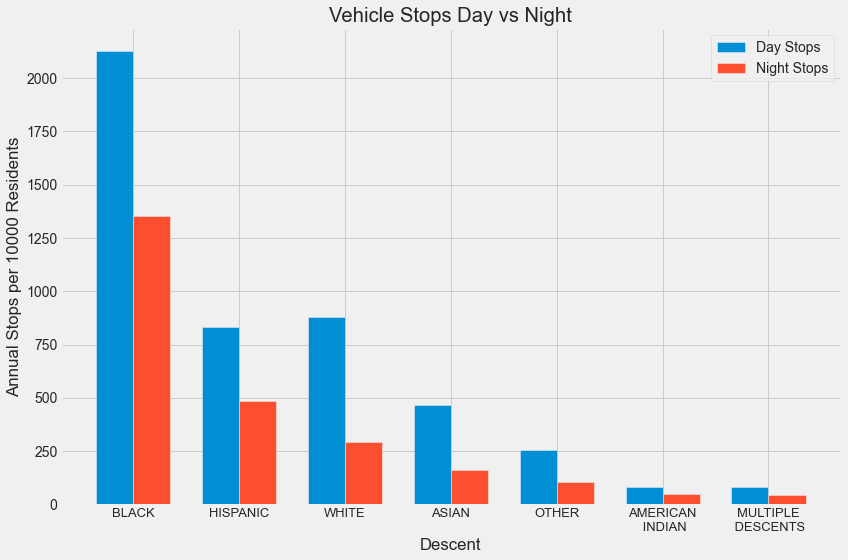

In [344]:
fig, ax = plt.subplots(figsize=(12,8))

ind = np.arange(len(vehicle_stops_10000))
width = 0.35


ax.bar(x=ind-width/2, height='stops_per_10000_day', width=width, data = vehicle_stops_10000, label = 'Day Stops')
ax.bar(x=ind+width/2, height='stops_per_10000_night', width=width, data = vehicle_stops_10000, label = 'Night Stops')

ax.set_xticks(ind)
ax.set_xticklabels(['BLACK', 'HISPANIC', 'WHITE', 'ASIAN', 'OTHER', 'AMERICAN\n INDIAN', 'MULTIPLE\n DESCENTS'], fontsize=13)
ax.set_title('Vehicle Stops Day vs Night')
ax.set_ylabel('Annual Stops per 10000 Residents')
ax.set_xlabel('Descent')
plt.legend()
plt.tight_layout()
plt.savefig('Vehicle Stops Night vs Day.jpg', padinches=1)

In [345]:
stop_type_race = pd.pivot_table(df, index='Descent Description', columns='Stop Type', values='count', aggfunc=np.sum)
stop_type_race.columns = stop_type_race.columns.astype('str')
stop_type_race = stop_type_race.reset_index()

In [346]:
stop_type_race['order'] = np.array([6, 4, 1, 2, 7, 5, 3])
stop_type_race = stop_type_race.set_index('order')
stop_type_race.sort_index(inplace=True)
stop_type_race.columns

Index(['Descent Description', 'PED', 'VEH'], dtype='object', name='Stop Type')

In [348]:
stop_type_race['stops_per_10000_ped'] = stop_type_race.apply(lambda row: 1000 * row['PED']/la_population[row['Descent Description']], axis=1)
stop_type_race['stops_per_10000_veh'] = stop_type_race.apply(lambda row: 1000 * row['VEH']/la_population[row['Descent Description']], axis=1)


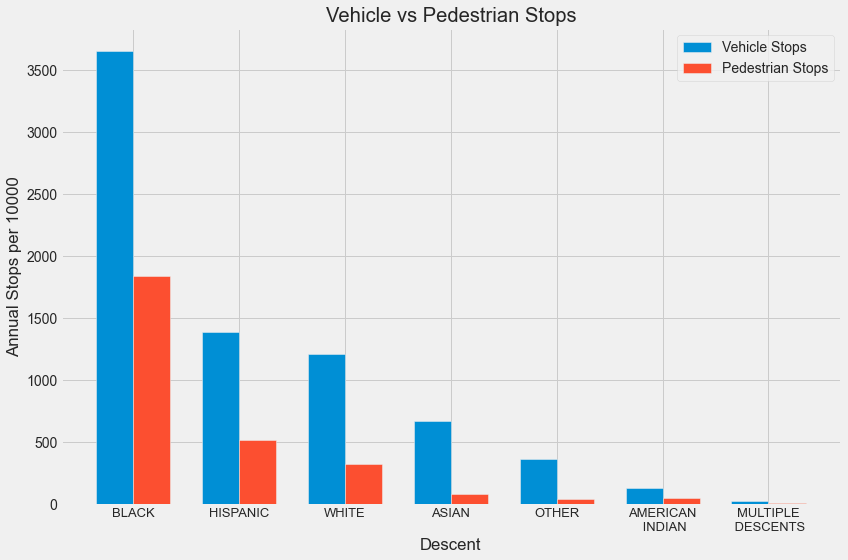

In [349]:
fig, ax = plt.subplots(figsize=(12,8))

ind = np.arange(len(stop_type_race))
width = 0.35


ax.bar(x=ind-width/2, height='stops_per_10000_veh', width=width, data = stop_type_race, label = 'Vehicle Stops')
ax.bar(x=ind+width/2, height='stops_per_10000_ped', width=width, data = stop_type_race, label = 'Pedestrian Stops')

ax.set_xticks(ind)
ax.set_xticklabels(['BLACK', 'HISPANIC', 'WHITE', 'ASIAN', 'OTHER', 'AMERICAN\n INDIAN', 'MULTIPLE\n DESCENTS'], fontsize=13)
ax.set_title('Vehicle vs Pedestrian Stops')
plt.legend()
ax.set_xlabel('Descent')
ax.set_ylabel('Annual Stops per 10000')
plt.tight_layout()
plt.savefig('vehicle_vs_pedestrian_stops_by_race.jpg')

## Post Stop Activity

In [350]:
post_stop = pd.pivot_table(data=df, index=['Descent Description'], columns='Post Stop Activity Indicator', values='count', aggfunc=np.sum)
post_stop.columns = post_stop.columns.astype('str')
post_stop = post_stop.reset_index()
post_stop

Post Stop Activity Indicator,Descent Description,N,Y
0,AMERICAN INDIAN,4316,1089
1,ASIAN,281269,42717
2,BLACK,1315051,693154
3,HISPANIC,2470609,1039095
4,MULTI-DESCENTS,4534,2991
5,OTHER,329449,39156
6,WHITE,1392122,275736


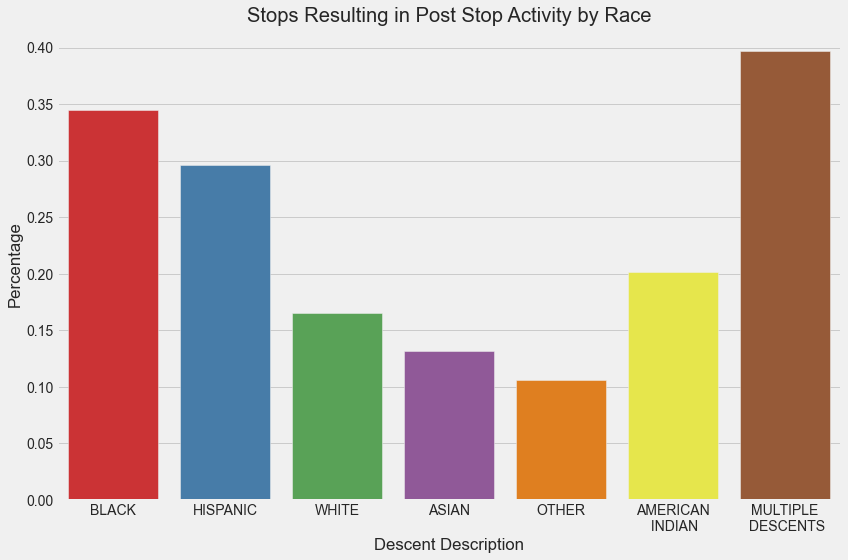

In [351]:
post_stop['Post Stop %'] = post_stop['Y'] / (post_stop['Y'] + post_stop['N'])
post_stop

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x = 'Descent Description', y = 'Post Stop %', data = post_stop, order=['BLACK', 'HISPANIC', 'WHITE', 'ASIAN', 'OTHER', 'AMERICAN INDIAN', 'MULTI-DESCENTS'], ax=ax, palette='Set1')

ax.set_title('Stops Resulting in Post Stop Activity by Race')
ax.set_xticks(np.arange(post_stop.shape[0]))
ax.set_xticklabels(['BLACK', 'HISPANIC', 'WHITE', 'ASIAN', 'OTHER', 'AMERICAN\n INDIAN', 'MULTIPLE\n DESCENTS'])
ax.set_ylabel('Percentage')
plt.tight_layout()
plt.savefig('stops_resulting_in_post_stop_activity.jpg', pad_inches=1)

In [352]:
post_stop

Post Stop Activity Indicator,Descent Description,N,Y,Post Stop %
0,AMERICAN INDIAN,4316,1089,0.201480
1,ASIAN,281269,42717,0.131848
2,BLACK,1315051,693154,0.345161
3,HISPANIC,2470609,1039095,0.296063
4,MULTI-DESCENTS,4534,2991,0.397475
5,OTHER,329449,39156,0.106228
6,WHITE,1392122,275736,0.165323


In [353]:
post_stop_year = pd.pivot_table(data=df, index=['Stop Year', 'Descent Description'], columns='Post Stop Activity Indicator', values='count', aggfunc=np.sum)
post_stop_year.columns = post_stop_year.columns.astype('str')
post_stop_year = post_stop_year.reset_index()
post_stop_year2010 = post_stop_year[post_stop_year['Stop Year'].between(2010, 2014)]
post_stop_year2015 = post_stop_year[post_stop_year['Stop Year'].between(2015, 2019)]

In [354]:
post_stop_year_2010 = post_stop_year2010.groupby('Descent Description')['N', 'Y'].sum().reset_index()
post_stop_year_2015 = post_stop_year2015.groupby('Descent Description')['N', 'Y'].sum().reset_index()
post_stop_year_2010['Post Stop %'] = post_stop_year_2010['Y'] / (post_stop_year_2010['Y'] + post_stop_year_2010['N'])
post_stop_year_2015['Post Stop %'] = post_stop_year_2015['Y'] / (post_stop_year_2015['Y'] + post_stop_year_2015['N'])

post_stop_year_2010['order'] = np.array([6,4,1,2,7,5,3])
post_stop_year_2015['order'] = np.array([6,4,1,2,7,5,3])

post_stop_year_2010 = post_stop_year_2010.sort_values('order')

post_stop_year_2015 = post_stop_year_2015.sort_values('order')


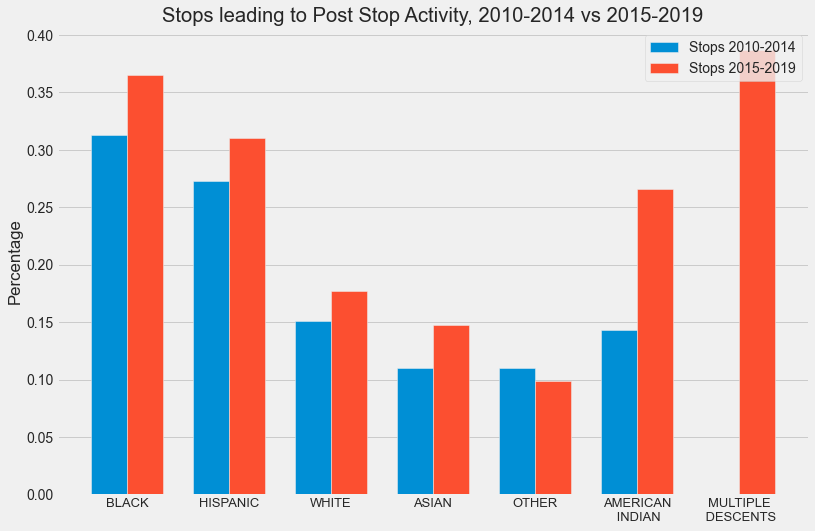

In [355]:
fig, ax6 = plt.subplots(figsize=(12, 8))

ind
width = 0.35

ax6.bar(x = ind-width/2, height=post_stop_year_2010['Post Stop %'], width=width, label='Stops 2010-2014')
ax6.bar(x = ind+width/2, height=post_stop_year_2015['Post Stop %'], width=width, label='Stops 2015-2019')
ax6.set_title('Post Stop Activity - 2010-2014 vs 2015-2019')
ax6.set_ylabel('Percentage')
ax6.set_title('Stops leading to Post Stop Activity, 2010-2014 vs 2015-2019')
ax6.set_xticks(ind)
ax6.set_xticklabels(['BLACK', 'HISPANIC', 'WHITE', 'ASIAN', 'OTHER', 'AMERICAN\n INDIAN', 'MULTIPLE\n DESCENTS'], fontsize=13)
ax6.grid(False, axis = 'x')
ax6.legend(loc='upper right')

plt.savefig('post_stop_activity_compared.jpg')


In [356]:
post_stop_decade = pd.concat([post_stop_year_2010, post_stop_year_2015], axis=1)
post_stop_decade.columns = ['Descent Description', 'N', 'Y', 'Post Stop %', 'order', 'Descent Description', 'N_2015', 'Y_2015', 'Post Stop %_2015', 'order']
post_stop_decade

post_stop_decade['percent_change'] = post_stop_decade['Post Stop %_2015'] / post_stop_decade['Post Stop %'] - 1
post_stop_decade


,Descent Description,N,Y,Post Stop %,order,Descent Description,N_2015,Y_2015,Post Stop %_2015,order,percent_change
2,BLACK,673487,307035,0.313134,1,BLACK,594151,342186,0.365452,1,0.167077
3,HISPANIC,1305477,489058,0.272526,2,HISPANIC,1068606,481660,0.310695,2,0.140055
6,WHITE,841139,149422,0.150846,3,WHITE,508448,109154,0.176738,3,0.171649
1,ASIAN,142108,17522,0.109766,4,ASIAN,119694,20644,0.147102,4,0.340138
5,OTHER,208376,25731,0.109911,5,OTHER,120563,13188,0.098601,5,-0.102903
0,AMERICAN INDIAN,2652,444,0.143411,6,AMERICAN INDIAN,1517,549,0.265731,6,0.852934
4,MULTI-DESCENTS,0,0,NaN,7,MULTI-DESCENTS,3706,2337,0.386728,7,NaN
